# Convolutional neural networks

We have seen before that neural networks are quite good at dealing with images, and even one-layer perceptron is able to recognize handwritten digits from MNIST dataset with reasonable accuracy. However, MNIST dataset is very special, and all digits are centered inside the image, which makes the task simpler.

In real life, we want to be able to recognize objects on the picture regardless of their exact location in the image. Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image.  

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units. We will also import `tfcv` helper library that contain some useful functions that we do not want to define inside this notebook to keep the code short and clean.

In [3]:
# Tensorflow Computer Vision Helper

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

def plot_convolution(data,t,title=''):
    fig, ax = plt.subplots(2,len(data)+1,figsize=(8,3))
    fig.suptitle(title,fontsize=16)
    tt = np.expand_dims(np.expand_dims(t,2),2)
    for i,im in enumerate(data):
        ax[0][i].imshow(im)
        ximg = np.expand_dims(np.expand_dims(im,2),0)
        cim = tf.nn.conv2d(ximg,tt,1,'SAME')
        ax[1][i].imshow(cim[0][:,:,0])
        ax[0][i].axis('off')
        ax[1][i].axis('off')
    ax[0,-1].imshow(t)
    ax[0,-1].axis('off')
    ax[1,-1].axis('off')
    #plt.tight_layout()
    plt.show()

def plot_results(hist):
    fig,ax = plt.subplots(1,2,figsize=(15,3))
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')
    for x in ['acc','val_acc']:
        ax[0].plot(hist.history[x])
    for x in ['loss','val_loss']:
        ax[1].plot(hist.history[x])
    plt.show()

def display_dataset(dataset, labels=None, n=10, classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    for i in range(n):
        ax[i].imshow(dataset[i])
        ax[i].axis('off')
        if classes is not None and labels is not None:
            ax[i].set_title(classes[labels[i][0]])

def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return im.format=='JPEG'
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image or wrong format: {}".format(fn))
            os.remove(fn)

def load_cats_dogs_dataset(batch_size=64):
    if not os.path.exists('data/PetImages'):
        print("Extracting the dataset")
        with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
            zip_ref.extractall('data')
    print("Checking dataset")
    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')
    data_dir = 'data/PetImages'
    print("Loading dataset")
    ds_train = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = 'training',
        seed = 13,
        image_size = (224,224),
        batch_size = batch_size
    )
    ds_test = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = 'validation',
        seed = 13,
        image_size = (224,224),
        batch_size = batch_size
    )
    return ds_train,ds_test

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
#%pip install tfcv
#import tfcv
#from tfcv import *

In this example, we will focus on the MNIST dataset that we have seen before, and on image classification. We will start by loading the dataset using Keras built-in functions.

In [15]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

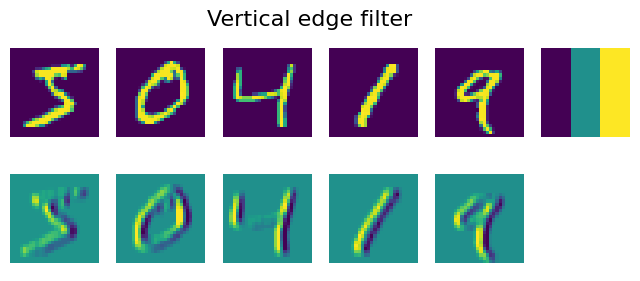

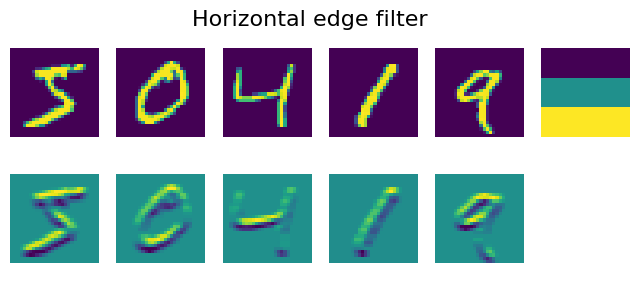

In [16]:
plot_convolution(x_train[:5],[[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]],'Vertical edge filter')
plot_convolution(x_train[:5],[[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]],'Horizontal edge filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. Those filters are in fact similar to neural structures that are available in the vision system of some animals.

<img src="https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/4-ComputerVision/07-ConvNets/images/lmfilters.jpg?raw=1" width="400"/>

However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem. To do that, we introduce **convolutional layers**.

## Covolutional layers

To make the weights of convolutional layer trainable, we need somehow to reduce the process of applying convolutional filter window to the image to the matrix operations, which can then be subject to backward propagation training. To do this, we use a clever matrix transformation, which we call **im2col**.

Suppose we have a small image $\mathbf{x}$, with the following pixels:

$$
\mathbf{x} = \left(
         \begin{array}{ccccc}
           a & b & c & d & e \\
           f & g & h & i & j \\
           k & l & m & n & o \\
           p & q & r & s & t \\
           u & v & w & x & y \\
         \end{array}
     \right)
$$

And we want to apply two conv filters, with the following weights:
$$
W^{(i)} = \left(\begin{array}{ccc}
            w^{(i)}_{00} & w^{(i)}_{01} & w^{(i)}_{02} \\
            w^{(i)}_{10} & w^{(i)}_{11} & w^{(i)}_{12} \\
            w^{(i)}_{20} & w^{(i)}_{21} & w^{(i)}_{22} \\
            \end{array}\right)
$$

When applying the convolution, the first pixel of the result would be obtained by element-wise multiplication of
$\left(\begin{array}{ccc}
  a & b & c \\
  f & g & h \\
  k & l & m \\
\end{array}\right)$ and $W^{(i)}$, the second element - by multiplying by $\left(\begin{array}{ccc}
  b & c & d \\
  g & h & i \\
  l & m & n \\
\end{array}\right)$ by $W^{(i)}$, and so on.

To formalize this process, let's extract all $3\times3$ fragments of the original image $x$ into the following matrix:

$$
\mathrm{im2col}(x) = \left[
        \begin{array}{cccccc}
          a & b & \ldots & g & \ldots & m \\
          b & c & \ldots & h & \ldots & n \\
          c & d & \ldots & i & \ldots & o \\
          f & g & \ldots & l & \ldots & r \\
          g & h & \ldots & m & \ldots & s \\
          h & i & \ldots & n & \ldots & t \\
          k & l & \ldots & q & \ldots & w \\
          l & m & \ldots & r & \ldots & x \\
          m & n & \ldots & s & \ldots & y \\
        \end{array}
    \right]
$$

Each column of this matrix corresponds to each $3\times3$ subregion of the original image. Now, to get the result of the convolution, we just need to multiply this matrix by the matrix or weights
$$
\mathbf{W} = \left[
         \begin{array}{cccccccc}
            w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02} & w^{(0)}_{10} & w^{(0)}_{11} & \ldots & w^{(0)}_{21} & w^{(0)}_{22} \\
            w^{(1)}_{00} & w^{(1)}_{01} & w^{(1)}_{02} & w^{(1)}_{10} & w^{(1)}_{11} & \ldots & w^{(1)}_{21} & w^{(1)}_{22} \\
         \end{array}
       \right]
$$
(each row of this matrix contains weights of $i$-th filter, flattened into one row)

So the application of a convolution filter to the original image can be replaced by matrix multiplication, which we already know how to handle using back prop:
$$
C(x) = W\times\mathbf{im2col}(x)
$$

Convolutional layers are defined using `Conv2d` class. We need to specify the following:
* `filters` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 24x24x9. The spatial dimension is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flatten 24x24x9 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers.

In [17]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=9, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 9)           │             234 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          51,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,084 (203.45 KB)

 Trainable params: 52,084 (203.45 KB)

 Non-trainable params: 0 (0.00 B)

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

> **Note**: In most of the practical cases, we want to apply convolutional layers to color images. Thus, `Conv2D` layer expects the input to be of the shape $W\times H\times C$, where $W$ and $H$ are width and height of the image, and $C$ is the number of color channels. For grayscale images, we need the same shape with $C=1$.

We need to reshape our data before starting training:

In [18]:
x_train_c = np.expand_dims(x_train,3)
x_test_c = np.expand_dims(x_test,3)
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.8836 - loss: 0.3865 - val_acc: 0.9736 - val_loss: 0.0963
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - acc: 0.9739 - loss: 0.0911 - val_acc: 0.9799 - val_loss: 0.0636
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - acc: 0.9813 - loss: 0.0629 - val_acc: 0.9831 - val_loss: 0.0536
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.9836 - loss: 0.0541 - val_acc: 0.9822 - val_loss: 0.0545
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - acc: 0.9859 - loss: 0.0483 - val_acc: 0.9846 - val_loss: 0.0458


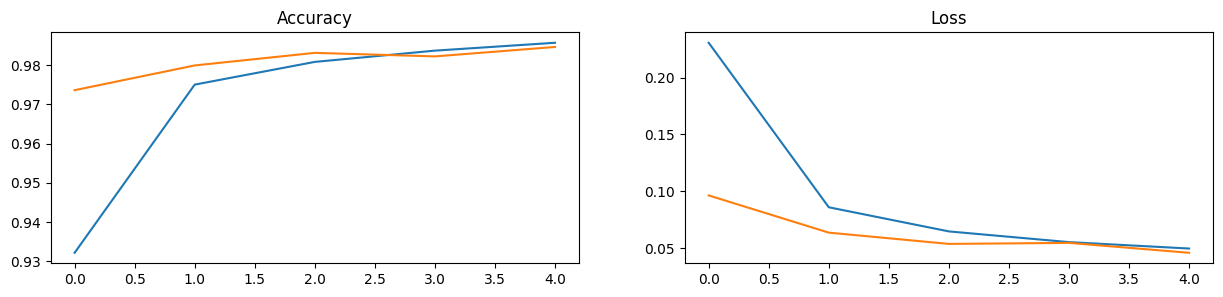

In [19]:
plot_results(hist)

As you can see, we are able to achieve higher accuracy, and much faster (in terms of number of epochs), compared to the fully-connected networks from previous unit. However, the training itself requires more resources, and may be slower on non-GPU computers.

## Visualizing Convolutional Layers

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

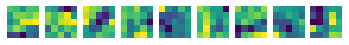

In [ ]:
fig,ax = plt.subplots(1,9)
l = model.layers[0].weights[0]
for i in range(9):
    ax[i].imshow(l[...,0,i])
    ax[i].axis('off')

You can see that some of those filters look like they can recognize some oblique strokes, while others look pretty random.

> **Task**: Train the same network with 3x3 filters and visualize them. Do you see more familiar patterns?

## Multi-layered CNNs and pooling layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical lines, but we can apply further convolutional layers on top of them to look for higher-level patterns, such as primitive shapes. Then more convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify.

When doing so, we may also apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within sliding 3x3 window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the **pooling layers**:

 * **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
 * **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

![An image showing several convolutional layers with pooling layers.](https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/4-ComputerVision/07-ConvNets/images/cnn-pyramid.png?raw=1)

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called **pyramid architecture**.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3210      
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
____________________________________________________

Notice that the number of trainable parameters (~8.5K) is dramatically smaller than in previous cases. This happens because convolutional layers in general have few parameters, and dimensionality of the image before applying final dense layer is significantly reduced. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [ ]:
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0723 - acc: 0.9780 - val_loss: 0.0423 - val_acc: 0.9861
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0523 - acc: 0.9842 - val_loss: 0.0425 - val_acc: 0.9866
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0448 - acc: 0.9868 - val_loss: 0.0403 - val_acc: 0.9865
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0383 - acc: 0.9886 - val_loss: 0.0323 - val_acc: 0.9888
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0331 - val_acc: 0.9896


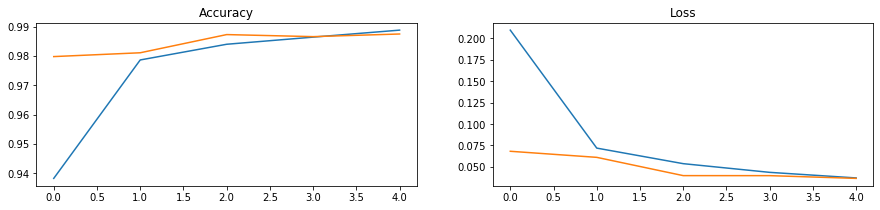

In [ ]:
plot_results(hist)

What you should probably observe is that we are able to achieve higher accuracy than with just one layer, and much faster in terms of number of epochs - just with 1 or 2 epochs. It means that sophisticated network architecture needs much fewer data to figure out what is going on, and to extract generic patterns from our images. However, training also takes longer, and requires a GPU.

## Playing with real images from the CIFAR-10 dataset

While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore more advanced dataset of pictures of different objects, called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). It contains 60k 32x32 images, divided into 10 classes.

In [7]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

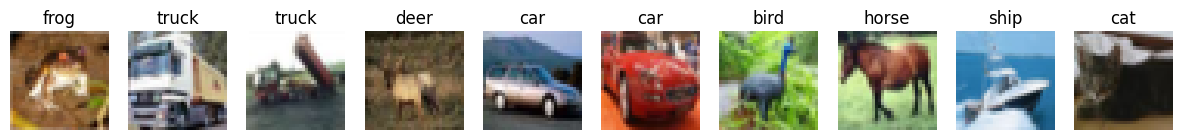

In [8]:
display_dataset(x_train,y_train,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above, the main difference being 3 input color channels instead of 1.

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.

In [23]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - acc: 0.3291 - loss: 1.8155 - val_acc: 0.4809 - val_loss: 1.4325
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - acc: 0.4970 - loss: 1.3990 - val_acc: 0.5378 - val_loss: 1.2923
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - acc: 0.5550 - loss: 1.2474 - val_acc: 0.5747 - val_loss: 1.2017
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - acc: 0.5910 - loss: 1.1573 - val_acc: 0.5858 - val_loss: 1.1673
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - acc: 0.6074 - loss: 1.1035 - val_acc: 0.5976 - val_loss: 1.1449
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - acc: 0.6261 - loss: 1.0515 - val_acc: 0.5950 - val_loss: 1.1692
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - acc: 0.6501 - loss: 0.9899 - val_acc: 0.6059 - val_loss: 1.1344
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - acc: 0.6611 - loss: 0.9590 - val_acc: 0.6216 - val_loss: 1.0881
Epoch 9/10
1563/1563 ━━━

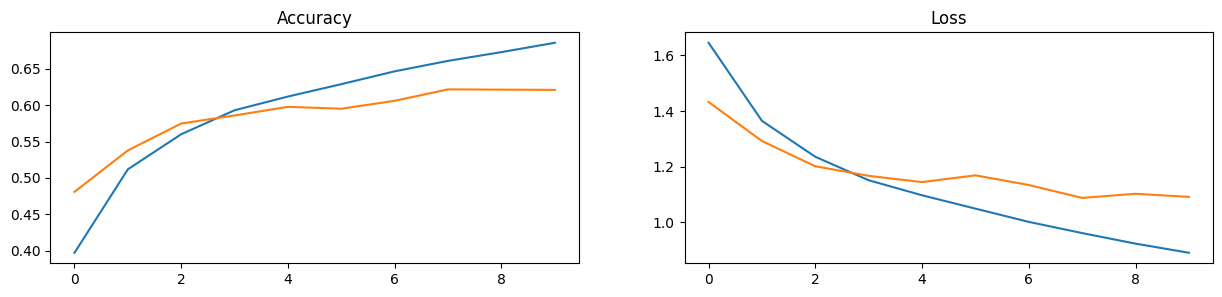

In [24]:
plot_results(hist)

The accuracy that we have been able to achieve with few epochs of training does not seem too great. However, remember that bling guessing would only give us 10% accuracy, and that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy in such a short training time seems like a good accomplishment.

## Takeaways

In this unit, we have learned the main concept behind computer vision neural networks - convolutional networks. Real-life architectures that power image classification, object detection, and even image generation networks are all based on CNNs, just with more layers and some additional training tricks.

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 10)          │             760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 16)          │           4,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,910 (249.65 KB)

 Trainable params: 63,910 (249.65 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - acc: 0.3469 - loss: 1.7679 - val_acc: 0.4785 - val_loss: 1.4409
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - acc: 0.5144 - loss: 1.3409 - val_acc: 0.5273 - val_loss: 1.3374
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 28ms/step - acc: 0.5625 - loss: 1.2279 - val_acc: 0.5704 - val_loss: 1.2012
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - acc: 0.6027 - loss: 1.1237 - val_acc: 0.5753 - val_loss: 1.1913
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - acc: 0.6241 - loss: 1.0531 - val_acc: 0.5936 - val_loss: 1.1755
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - acc: 0.6421 - loss: 1.0084 - val_acc: 0.6229 - val_loss: 1.0752
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - acc: 0.6668 - loss: 0.9491 - val_acc: 0.6253 - val_loss: 1.0662
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - acc: 0.6806 - loss: 0.9052 - val_acc: 0.6341 - val_loss: 1.0498
Epoch 9/10
1563/1563 ━━━

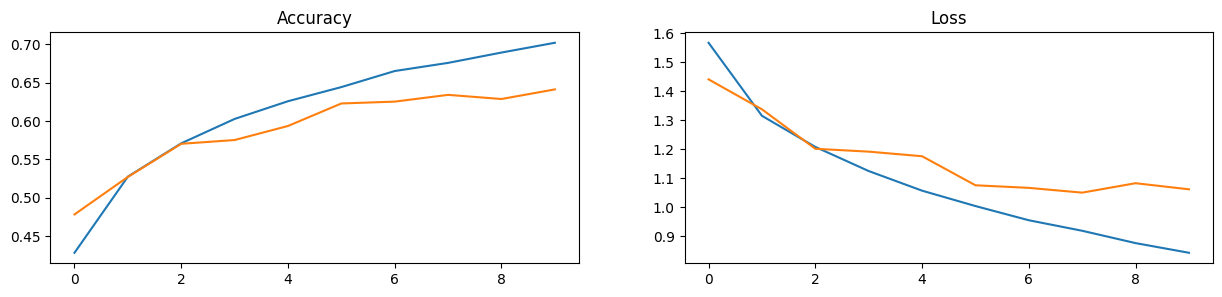

In [11]:
plot_results(hist)

In [21]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'leaky_relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - acc: 0.3153 - loss: 1.8503 - val_acc: 0.4601 - val_loss: 1.4739
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - acc: 0.4992 - loss: 1.3875 - val_acc: 0.5319 - val_loss: 1.2926
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - acc: 0.5540 - loss: 1.2485 - val_acc: 0.5425 - val_loss: 1.2901
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - acc: 0.5838 - loss: 1.1616 - val_acc: 0.5648 - val_loss: 1.2176
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - acc: 0.6127 - loss: 1.0933 - val_acc: 0.5739 - val_loss: 1.2164
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - acc: 0.6335 - loss: 1.0359 - val_acc: 0.5876 - val_loss: 1.1728
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - acc: 0.6565 - loss: 0.9693 - val_acc: 0.5845 - val_loss: 1.1793
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - acc: 0.6722 - loss: 0.9247 - val_acc: 0.5906 - val_loss: 1.1761
Epoch 9/10
1563/1563 ━━━

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 8, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'leaky_relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 10, 10, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,958 (245.93 KB)

 Trainable params: 62,958 (245.93 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - acc: 0.3459 - loss: 1.7720 - val_acc: 0.4973 - val_loss: 1.3899
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - acc: 0.5208 - loss: 1.3322 - val_acc: 0.5547 - val_loss: 1.2437
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - acc: 0.5842 - loss: 1.1754 - val_acc: 0.5836 - val_loss: 1.1785
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - acc: 0.6156 - loss: 1.0814 - val_acc: 0.5900 - val_loss: 1.1749
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - acc: 0.6472 - loss: 1.0109 - val_acc: 0.5951 - val_loss: 1.1467
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - acc: 0.6672 - loss: 0.9447 - val_acc: 0.6108 - val_loss: 1.1088
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - acc: 0.6839 - loss: 0.8948 - val_acc: 0.6186 - val_loss: 1.1097
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - acc: 0.7077 - loss: 0.8330 - val_acc: 0.6256 - val_loss: 1.0775
Epoch 9/10
1563/1563 ━━━